In [1]:
import numpy as np
import xarray as xr
import salishsea_tools.river_202108 as rivers
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.optimize import curve_fit

In [2]:
def wrangle_df(river_dataframe, month, month_num, month_days):
    test = river_dataframe[['YEAR','DD', month]]
    mapping = {test.columns[0]: 'YYYY', test.columns[2]: 'DISCHARGE'}
    test2 = test.rename(columns=mapping)
    test2['MM'] = month_num
    test2 = test2.drop(test2[test2['DD'] > month_days].index)
    return test2

In [3]:
def add_dt(df):
    listy = [str(int(year)) for year in df['YYYY']]
    listm = [str.zfill(str(int(month)),2) for month in df['MM']]
    listd = [str.zfill(str(int(day)),2) for day in df['DD']]

    lst = list([listy, listm, listd])

    listdt = list(map('-'.join, zip(*lst)))

    date_format = '%Y-%m-%d'
    listdt_obj = [datetime.strptime(dt_str, date_format) for dt_str in listdt]

    return listdt_obj

In [4]:
def transform_df(df):
    January = wrangle_df(df, 'Jan', 1, 31)
    February = wrangle_df(df, 'Feb', 2, 28)
    March = wrangle_df(df, 'Mar', 3, 31)
    April = wrangle_df(df, 'Apr', 4, 30)
    May = wrangle_df(df, 'May', 5, 31)
    June = wrangle_df(df, 'Jun', 6, 30)
    July = wrangle_df(df, 'Jul', 7, 31)
    August = wrangle_df(df, 'Aug', 8, 31)
    September = wrangle_df(df, 'Sep', 9, 30)
    October = wrangle_df(df, 'Oct', 10, 31)
    November = wrangle_df(df, 'Nov', 11, 30)
    December = wrangle_df(df, 'Dec', 12, 31)

    df_new = pd.DataFrame(np.vstack((January.to_numpy(), February.to_numpy(), March.to_numpy(), April.to_numpy(), May.to_numpy(), June.to_numpy(), July.to_numpy(), August.to_numpy(), September.to_numpy(), October.to_numpy(), November.to_numpy(), December.to_numpy())), columns= ['YYYY', 'DD', 'DISCHARGE', 'MM'])
    
    df_new['DateTime'] = add_dt(df_new)

    return df_new

In [5]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [6]:
# fw_rivers = xr.open_dataset('/ocean/cdonaldson/research_runs/long_dye_tracers/extractions/SalishSeaCast_river_trace_day_avg_Fraser_all_20170101_20200101.nc')
fw_rivers = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_Fraser_all_20120101_20140101.nc')

In [124]:
time = fw_rivers['time'].to_numpy()
Fraser_file = '1d_new_volume_fraser_river_s2017_1096_dep_0_40.csv'
dep_idx = int(Fraser_file[-6:-4])
Fraser_arr = pd.read_csv('dye_to_vol/' + Fraser_file)['0'].to_numpy()

In [125]:
Fraser_obs = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/compare_daily_river/Fraser_Hope.csv',header=1)
Fraser_obs = Fraser_obs[Fraser_obs['PARAM'] == 1]
Fraser_obs = transform_df(Fraser_obs).sort_values(by='DateTime')

In [126]:
Fraser_mod = pd.read_csv('river_dailies_to_ts_fraser_20170101_20200101.csv')
Fraser_mod['date'] = pd.to_datetime(Fraser_mod['date'], format='%m-%d-%Y')

In [127]:
obs_sel = (Fraser_obs['DateTime'] >= '2017-01-01') & (Fraser_obs['DateTime'] <= '2018-12-31')
Fraser_obs = Fraser_obs[obs_sel]

In [128]:
rho = 1026
runoff_to_m3 = 86400 * (500*440)/rho

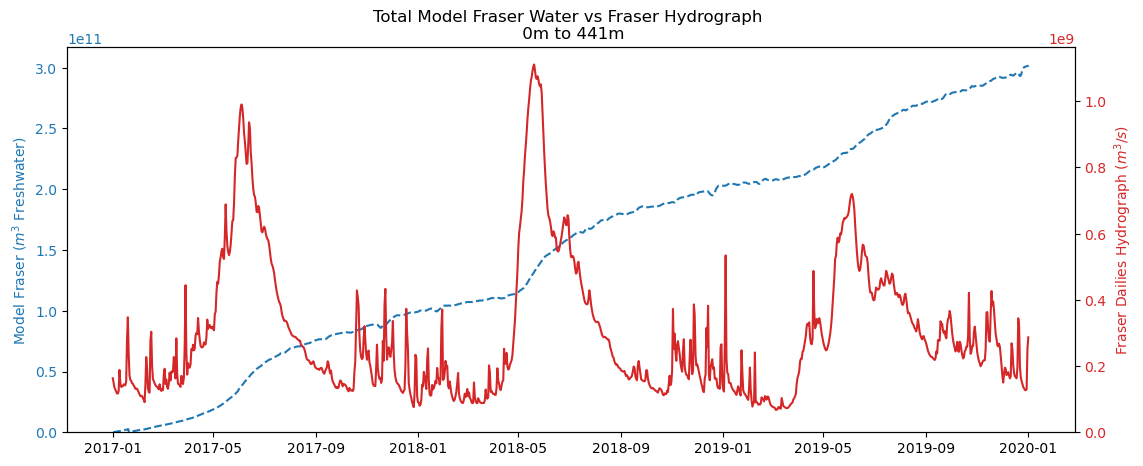

In [129]:
fig, ax1 = plt.subplots(1, 1, figsize=(13, 5))

color1 = 'tab:blue'
ax1.set_title('Total Model Fraser Water vs Fraser Hydrograph \n 0m to {}m'.format( int(float(fw_rivers['depth'][dep_idx-1].values))))
ax1.plot(time, Fraser_arr, linestyle='--', color=color1)
ax1.set_ylabel(r'Model Fraser ($m^3$ Freshwater)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, None)

color2 = 'tab:red'
ax2 = ax1.twinx()
ax2.plot(Fraser_mod['date'], runoff_to_m3*Fraser_mod['Fraser [kg/m2/s]'], color=color2)
ax2.set_ylabel(r'Fraser Dailies Hydrograph ($m^3/s$)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, None)

plt.savefig('look_at_results/timeseries_plots/Fraser_modelandobs_volume.png')

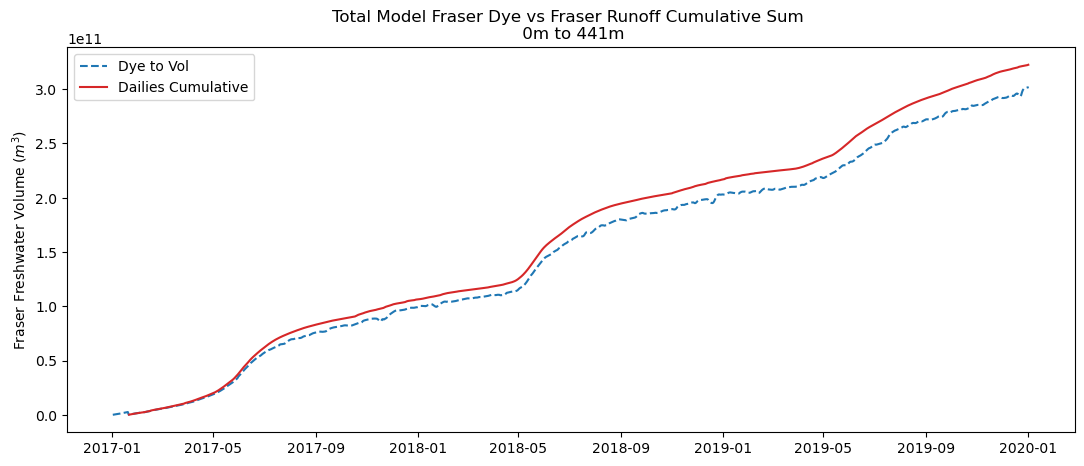

In [130]:
fig, ax1 = plt.subplots(1, 1, figsize=(13, 5))

color1 = 'tab:blue'
ax1.set_title('Total Model Fraser Dye vs Fraser Runoff Cumulative Sum \n 0m to {}m'.format( int(float(fw_rivers['depth'][dep_idx-1].values))))
ax1.plot(time, Fraser_arr, linestyle='--', color=color1, label='Dye to Vol')

color2 = 'tab:red'
ax1.plot(Fraser_mod['date'][20:], np.cumsum(runoff_to_m3*Fraser_mod['Fraser [kg/m2/s]'][20:]), color='tab:red', label='Dailies Cumulative')
ax1.set_ylabel(r'Fraser Freshwater Volume ($m^3$)')
ax1.legend()

plt.savefig('look_at_results/timeseries_plots/Fraser_modelandmodelin_volume.png')

## Exponential fit

In [131]:
last_2019 = xr.open_dataset('/ocean/cdonaldson/research_runs/long_dye_tracers/monthly_results/SalishSea_1d_20191231_20191231_rivr_T.nc')
volume = mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0] * (1-tmask[0])

rho = 1026  ## do 1/rho and pass it into it
volume_dims = np.array([volume.to_numpy(), volume.to_numpy()])[0:1] ## do this once, pass volume dims into it
data_np = last_2019.fraser_river[:, 0:40].values
river_arr = (1/rho) * np.multiply(volume_dims[:, 0:40], data_np) ## try again as the xarrays? and multiply by tmask so no need nansum (can acutally do that to volume)
river_sum_dec312019 = np.nansum(np.nansum(np.nansum(river_arr, axis=3), axis=2), axis=1)
river_sum_dec312019

array([3.10173183e+11])

In [132]:
idx0 = 20
idx1 = 364
idx2 = 729
idx3 = 1095

In [133]:
day0 = fw_rivers['time'][idx0]
day1 = fw_rivers['time'][idx1]
day2 = fw_rivers['time'][idx2]
day3 = fw_rivers['time'][idx3]

In [134]:
vol0 = Fraser_arr[idx0]
vol1 = Fraser_arr[idx1]
vol2 = Fraser_arr[idx2]
vol3 = Fraser_arr[idx3]

In [135]:
idxs = [idx0, idx1, idx2, idx3]
days = [day0.values, day1.values, day2.values, day3.values]
vols = [vol0, vol1, vol2, vol3]

In [136]:
def model(t, A, T):
    return A * (1 - np.exp(-t / T))

In [137]:
def model_inv(y, A, T):
    return -T * np.log(1 - (y/A))

In [138]:
t_data = idxs
Y_data = vols

# total volume of the salish sea is about 7.7e12 m^3
initial_guess = (1e12, 1)

popt, pcov = curve_fit(model, t_data, Y_data, p0=initial_guess)
A_opt, T_opt = popt

In [139]:
T_growthscale = T_opt
T_80pct = model_inv(A_opt*0.8, A_opt, T_opt)
T_90pct = model_inv(A_opt*0.9, A_opt, T_opt)
T_95pct = model_inv(A_opt*0.95, A_opt, T_opt)

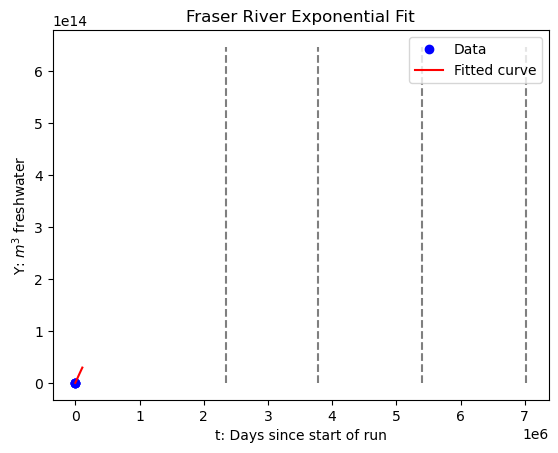

Optimized parameters:
A = 647.1086479333607
T = 2344037.5228261407
T_R =  6422.0206104825775
T_80pct = 10335.843444943846
T_90pct = 14787.248924597712
T_95pct = 19238.654404251567


In [140]:
# Generate the fitted curve
t_fit = np.linspace(0, max(t_data)*100, 100)
Y_fit = model(t_fit, A_opt, T_opt)

# Plot the original data and the fitted curve
plt.plot(t_data, Y_data, 'bo', label='Data')
plt.plot(t_fit, Y_fit, 'r-', label='Fitted curve')
plt.vlines([T_opt, T_80pct, T_90pct, T_95pct], [0, 0, 0, 0], [A_opt, A_opt, A_opt, A_opt], 'k', linestyle='--', alpha=0.5)
plt.xlabel('t: Days since start of run')
plt.ylabel(r'Y: $m^3$ freshwater')
plt.legend()
plt.title('Fraser River Exponential Fit')
plt.show()

# Print the optimized parameters
print("Optimized parameters:")
print("A =", A_opt/1e12)
print("T =", T_opt)
print('T_R = ', T_opt/365)
print('T_80pct =', T_80pct/365)
print('T_90pct =', T_90pct/365)
print('T_95pct =', T_95pct/365)

I started my run in 2017. If I let the Fraser get up to 80% of its SS value, it will be late 2022, leaving only 2023 availible for analysis. To get to 90 and 95, I would need to go farther.

To go back in time, I think I will want to do it so that I can run analysis on 2023, 2022, 2021, and 2020. If I go for the 95% value, I will need to spin up my Fraser for 11 years before running the subsequent 4, giving a total of 15 years of model run. I would need to start the model running in 2009.

Actually, I can finish 2020 and use that to jumpstart the run at 2013!

-> something is up with this fit and calculation. I get a value that is wayyy over!

In [141]:
t_data = np.arange(0, len(Fraser_arr))
Y_data = Fraser_arr

# total volume of the salish sea is about 7.7e12 m^3
initial_guess = (1e12, 1)

popt, pcov = curve_fit(model, t_data, Y_data, p0=initial_guess)
A_opt, T_opt = popt

In [142]:
T_growthscale = T_opt
T_80pct = model_inv(A_opt*0.8, A_opt, T_opt)
T_90pct = model_inv(A_opt*0.9, A_opt, T_opt)
T_95pct = model_inv(A_opt*0.95, A_opt, T_opt)

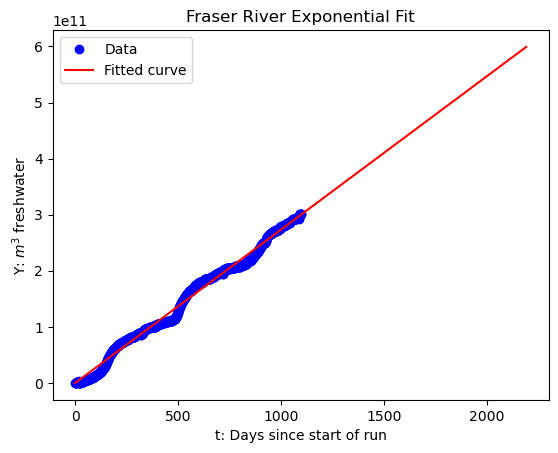

Optimized parameters:
A = 1023.430259965885
T = 3739217.0592133612
T_R =  10244.430299214688
T_80pct = 16487.774514844736
T_90pct = 23588.672493188278
T_95pct = 30689.570471531802


In [143]:
# Generate the fitted curve
t_fit = np.linspace(0, max(t_data)*2, 100)
Y_fit = model(t_fit, A_opt, T_opt)

# Plot the original data and the fitted curve
plt.plot(t_data, Y_data, 'bo', label='Data')
plt.plot(t_fit, Y_fit, 'r-', label='Fitted curve')
plt.xlabel('t: Days since start of run')
plt.ylabel(r'Y: $m^3$ freshwater')
plt.legend()
plt.title('Fraser River Exponential Fit')
plt.show()

# Print the optimized parameters
print("Optimized parameters:")
print("A =", A_opt/1e12)
print("T =", T_opt)
print('T_R = ', T_opt/365)
print('T_80pct =', T_80pct/365)
print('T_90pct =', T_90pct/365)
print('T_95pct =', T_95pct/365)